In [44]:
os.environ["LANGCHAIN_PROJECT"] = "VicAIAgen2.0"

In [45]:
from langchain.chat_models import init_chat_model

from langgraph.prebuilt import create_react_agent

from langgraph.checkpoint.memory import MemorySaver

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

model = init_chat_model("gpt-4o", model_provider="openai")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import re
import os
import glob

In [46]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage, BaseMessage
from langchain_openai import ChatOpenAI
import shutil
from langchain.tools import tool
from langgraph.graph import END
from langgraph.graph import MessagesState
import requests
from dataclasses import dataclass
from typing import List

#search = TavilySearchResults(max_results=3)

from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

# Add these to your state if you haven't already:
@dataclass
class MessagesState:
    messages: List[BaseMessage]
    last_summarized_at: int = 0  # <-- Add this field!



def tavily_search_full(query: str) -> str:
    """Searches the web using Tavily and returns detailed content."""
    headers = {
        "Authorization": f"Bearer {TAVILY_API_KEY}"
    }
    params = {
        "query": query,
        "max_results": 3,
        "include_raw_content": True,
        "search_depth": "advanced"
    }
    response = requests.post("https://api.tavily.com/search", headers=headers, json=params)
    data = response.json()
    
    results = data.get("results", [])
    formatted = ""
    for result in results:
        formatted += f"Title: {result['title']}\nURL: {result['url']}\nContent: {result.get('content', '')[:1000]}...\n\n"
    return formatted


def move_file(source: str, destination: str) -> str:
    """
    Move a file from `source` to `destination`.
    If destination is a directory (ends with a slash or has no extension),
    it will use the same filename.
    """
    if not os.path.isfile(source):
        return f"❌ Source file not found: {source}"

    # Check if destination is a directory
    _, ext = os.path.splitext(destination)
    looks_like_dir = destination.endswith(os.sep) or ext == ""
    if looks_like_dir:
        os.makedirs(destination, exist_ok=True)
        filename = os.path.basename(source)
        destination = os.path.join(destination, filename)
    else:
        os.makedirs(os.path.dirname(destination), exist_ok=True)

    try:
        shutil.move(source, destination)
        return f"✅ Moved `{source}` → `{destination}`"
    except Exception as e:
        return f"❌ Failed to move file: {e}"
    
def read_file(path: str) -> str:
    """
    Read and return the content of a text file.
    Only use for small text files.
    """
    if not os.path.isfile(path):
        return f"❌ File not found: {path}"
    try:
        with open(path, "r", encoding="utf-8") as f:
            content = f.read()
            return f"📄 Contents of `{path}`:\n/n{content[:1000]}{'...' if len(content) > 1000 else ''}"
    except Exception as e:
        return f"❌ Failed to read file: {e}"


def list_files(directory: str) -> str:
    """
    Lists the files and subdirectories in the given directory.
    """
    if not os.path.exists(directory):
        return f"❌ Directory does not exist: {directory}"
    try:
        items = os.listdir(directory)
        if not items:
            return f"📂 Directory is empty: {directory}"
        return f"📂 Contents of `{directory}`:\n" + "\n".join(f"- {item}" for item in items)
    except Exception as e:
        return f"❌ Failed to list directory: {e}"
    
mpl.use('Agg')

def _parse_oceanwave_file(filename):
    """Parses a single OceanWave3D data file."""
    data_list = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            row = []
            for part in parts:
                try:
                    value = float(part)
                except ValueError:
                    # Try to handle Fortran-style scientific notation like '1.234-56'
                    match = re.match(r'(\d+\.\d+)([+-]\d+)', part)
                    if match:
                        try:
                            value = float(f"{match.group(1)}E{match.group(2)}")
                        except ValueError:
                            value = 0.0 # Fallback if conversion still fails
                    else:
                        value = 0.0 # Fallback if it's not a standard float or known scientific notation
                row.append(value)
            # Ensure the row has the expected number of columns (X, Y, Z, optional 4th)
            if len(row) >= 3: # We need at least X, Y, Z
                 # Keep only the first 3 or 4 columns depending on expected format
                 # Sticking to 4 based on original code
                 if len(row) == 4:
                     data_list.append(row)
                 elif len(row) == 3:
                     # If only 3 columns, add a dummy 4th if needed, or adjust logic
                     # For now, assume the original 4-column structure was intended
                     # If your files only have 3 (X,Y,Z), adjust this part and slicing below
                     pass # Or append [row[0], row[1], row[2], 0.0] if 4 are always needed

    if not data_list:
        # Handle empty or unparseable file
        return np.empty((0, 4)) # Return empty array with expected columns

    return np.array(data_list)

# --- Langchain Tool Definition ---
@tool
def visualize_oceanwave_data(data_directory: str, output_gif_path: str) -> str:
    """
    Visualizes OceanWave3D simulation data found in the specified directory
    and saves the animation as a GIF file.

    Args:
        data_directory (str): The path to the directory containing the OceanWave3D
                              output files (e.g., 'fort.10', 'fort.11', ...).
        output_gif_path (str): The full path where the output GIF animation
                               should be saved (e.g., '/path/to/OceanWave.gif').

    Returns:
        str: A message indicating success and the path to the saved GIF,
             or an error message if visualization failed.
    """
    print(f"Attempting to visualize OceanWave3D data from: {data_directory}")
    print(f"Output will be saved to: {output_gif_path}")

    try:
        # === FILE COLLECTION ===
        file_pattern = os.path.join(data_directory, "fort.1*") # Standard pattern
        # Use glob to find files matching the pattern
        files = glob.glob(file_pattern)
        # Filter out any unexpected files if necessary (like .123 from original code)
        files = [f for f in files if '.123' not in os.path.basename(f)]
        # Sort files numerically based on the part after 'fort.'
        try:
             files = sorted(files, key=lambda x: int(os.path.basename(x).split('.')[-1]))
        except ValueError:
             print("Warning: Could not sort files numerically. Using default glob order.")
             files = sorted(files) # Fallback sorting

        if not files:
            return f"❌ Error: No 'fort.1*' files found in directory: {data_directory}"
        print(f"Found {len(files)} files to process.")

        # === PARSE FIRST FILE FOR SETUP ===
        try:
            first_data = _parse_oceanwave_file(files[0])
            if first_data.shape[0] == 0:
                 return f"❌ Error: First file '{files[0]}' is empty or could not be parsed."
        except Exception as e:
            return f"❌ Error parsing first file '{files[0]}': {e}"

        x_values = first_data[:, 0]
        y_values = first_data[:, 1]
        unique_x = np.unique(x_values)
        unique_y = np.unique(y_values)
        nx = len(unique_x)
        ny = len(unique_y)
        rows = first_data.shape[0]
        can_reshape = (nx * ny == rows)

        grid_shape = None
        if can_reshape:
            print("Data appears to be on a regular grid. Using meshgrid.")
            X, Y = np.meshgrid(unique_x, unique_y)
            # Ensure correct shape (rows=Y, columns=X)
            grid_shape = (ny, nx) # Correct order for numpy reshape
        else:
            print("Data does not form a regular grid or dimensions mismatch. Using scatter plot.")
            # Use raw data points directly for scatter plot
            X = x_values
            Y = y_values
            grid_shape = None # Explicitly mark as not gridded

        # === INITIAL PLOT SETUP ===
        plt.rcParams['figure.figsize'] = [12, 8] # Set figure size
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=30, azim=-60) # Set initial view angle

        # Initial plot element (surface or scatter)
        plot_element = None
        if grid_shape:
            # Reshape Z data according to the derived grid shape
            Z_initial = first_data[:, 2].reshape(grid_shape)
            plot_element = ax.plot_surface(X, Y, Z_initial, cmap='viridis', linewidth=0, antialiased=True, alpha=0.8)
        else:
            # Z data remains a 1D array for scatter
            Z_initial = first_data[:, 2]
            plot_element = ax.scatter(X, Y, Z_initial, c=Z_initial, cmap='viridis')

        # Add color bar
        fig.colorbar(plot_element, ax=ax, shrink=0.5, aspect=10, label='Surface Elevation η') # Adjusted aspect
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('η (Surface Elevation)')
        ax.set_title(f'Ocean Surface Elevation - Frame 0')
        # Set aspect ratio for better visualization
        ax.set_box_aspect([np.ptp(unique_x), np.ptp(unique_y), np.ptp(Z_initial) if Z_initial.size > 0 else 1])


        # === DETERMINE GLOBAL Z LIMITS ===
        print("Sampling files to determine Z limits...")
        z_mins, z_maxs = [], []
        # Sample a limited number of files for performance
        sample_files = files[:min(20, len(files))]
        for i, file in enumerate(sample_files):
            try:
                data = _parse_oceanwave_file(file)
                if data.shape[0] > 0:
                    z_mins.append(np.min(data[:, 2]))
                    z_maxs.append(np.max(data[:, 2]))
            except Exception as e:
                print(f"Warning: Error sampling file {file} for Z limits: {e}")

        if not z_mins or not z_maxs:
             # Fallback if sampling failed or all sampled files were empty/bad
             if first_data.shape[0] > 0:
                 z_min_global = np.min(first_data[:, 2])
                 z_max_global = np.max(first_data[:, 2])
             else: # Should not happen due to earlier check, but as a safeguard
                 z_min_global, z_max_global = -1, 1
                 print("Warning: Could not determine Z limits automatically. Using default [-1, 1].")
        else:
             z_min_global = min(z_mins)
             z_max_global = max(z_maxs)

        z_range = z_max_global - z_min_global
        if z_range < 1e-6: z_range = 1 # Avoid zero range
        # Add some padding to the limits
        z_min_final = z_min_global - z_range * 0.15
        z_max_final = z_max_global + z_range * 0.15
        ax.set_zlim(z_min_final, z_max_final)
        print(f"Global Z limits set to: [{z_min_final:.2f}, {z_max_final:.2f}]")


        # === ANIMATION UPDATE FUNCTION ===
        def update(frame):
            # Use 'nonlocal plot_element' if you need to modify the specific plot object
            # But clearing and replotting is often simpler for complex plots
            ax.clear() # Clear previous frame's contents

            try:
                data = _parse_oceanwave_file(files[frame])
                if data.shape[0] == 0:
                    print(f"Warning: Frame {frame} ({os.path.basename(files[frame])}) is empty or unparseable. Skipping.")
                    # Re-draw empty axes with labels/title to avoid blank frame
                    ax.set_xlabel('X')
                    ax.set_ylabel('Y')
                    ax.set_zlabel('η (Surface Elevation)')
                    ax.set_title(f'Ocean Surface Elevation - Frame {frame} (Data Missing)')
                    ax.set_zlim(z_min_final, z_max_final) # Maintain consistent Z limits
                    ax.view_init(elev=30, azim=-60) # Maintain view angle
                    # Maintain aspect ratio using limits from first frame or calculated ranges
                    try:
                        ax.set_box_aspect([np.ptp(unique_x), np.ptp(unique_y), z_range]) # Use calculated range
                    except NameError: # Fallback if ranges weren't calculated properly
                        ax.set_box_aspect([1,1,0.3]) # Default aspect
                    return [] # Return empty list for blitting if enabled, or just return

                current_Z = data[:, 2]

                local_plot_element = None
                if grid_shape:
                    # Ensure the data for this frame can also be reshaped
                    if current_Z.size == nx * ny:
                        Z_reshaped = current_Z.reshape(grid_shape)
                        local_plot_element = ax.plot_surface(X, Y, Z_reshaped, cmap='viridis', linewidth=0, antialiased=True, alpha=0.8)
                    else:
                        print(f"Warning: Frame {frame} data size mismatch. Expected {nx*ny}, got {current_Z.size}. Plotting as scatter.")
                        # Fallback to scatter if reshape fails for this frame
                        local_plot_element = ax.scatter(data[:, 0], data[:, 1], current_Z, c=current_Z, cmap='viridis')
                else:
                    # Plot as scatter using the X, Y defined initially (which are the raw coords)
                    local_plot_element = ax.scatter(X, Y, current_Z, c=current_Z, cmap='viridis')

                # Re-apply settings for each frame after clearing
                ax.set_zlim(z_min_final, z_max_final)
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('η (Surface Elevation)')
                ax.set_title(f'Ocean Surface Elevation - Frame {frame}\nFile: {os.path.basename(files[frame])}')
                ax.view_init(elev=30, azim=-60) # Keep consistent view

                # Try setting aspect ratio based on data ranges
                try:
                     ax.set_box_aspect([np.ptp(unique_x), np.ptp(unique_y), z_range])
                except NameError: # Fallback
                     ax.set_box_aspect([1,1,0.3])

                # Return the plot elements for blitting (though blit=False is set)
                # Returning the main plot element is good practice.
                return [local_plot_element] if local_plot_element else []

            except Exception as e:
                print(f"❌ Error processing frame {frame}, file {os.path.basename(files[frame])}: {e}")
                # Optionally, add error text to the plot for this frame
                ax.text2D(0.5, 0.5, f'Error loading frame {frame}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')
                # Re-apply basic settings even on error
                ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('η')
                ax.set_title(f'Ocean Surface Elevation - Frame {frame} (Error)')
                ax.set_zlim(z_min_final, z_max_final)
                ax.view_init(elev=30, azim=-60)
                return []

        # === CREATE AND SAVE ANIMATION ===
        print("Creating animation (this may take a while)...")
        # interval=200ms -> 5 fps. blit=False is often more robust for complex 3D plots.
        ani = FuncAnimation(fig, update, frames=len(files), interval=200, blit=False)

        # Ensure output directory exists
        output_dir = os.path.dirname(output_gif_path)
        if output_dir: # Only create if path includes a directory part
             os.makedirs(output_dir, exist_ok=True)

        print(f"Saving animation to {output_gif_path} ...")
        try:
            # Use PillowWriter for GIF saving
            writer = PillowWriter(fps=5) # Match fps to interval: 1000ms / 200ms = 5 fps
            ani.save(output_gif_path, writer=writer)
            plt.close(fig) # Close the plot figure to free memory
            print("Animation saved successfully.")
            return f"✅ Successfully generated OceanWave3D animation: {output_gif_path}"
        except Exception as e:
            plt.close(fig) # Ensure figure is closed even on error
            return f"❌ Error saving animation to '{output_gif_path}': {e}"

    except Exception as e:
        # Catch any broader errors during setup
        plt.close(fig) # Attempt to close figure if it was created
        import traceback
        traceback.print_exc() # Print full traceback for debugging
        return f"❌ An unexpected error occurred during visualization setup: {e}"

def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END


def summarize_conversation(state: MessagesState):
    """
    Summarize the previous conversation and prepend the summary
    as a SystemMessage to the beginning of the messages list.
    Retain the last Human and AI message pair before summarization.
    """
    messages_to_summarize = state.messages

    summarization_prompt = [
        SystemMessage(content="Please summarize the following conversation concisely, highlighting user identity, key questions, requests, and any important facts discussed. This summary will be used to provide context to the AI in future turns. Do not include conversational filler or conversational history structure (like 'Human: ...', 'AI: ...'). Just provide the summary content."),
        HumanMessage(content="Here is the conversation to summarize:\n\n" + "\n".join([f"{type(msg).__name__}: {msg.content}" for msg in messages_to_summarize]))
    ]

    response = model.invoke(summarization_prompt)
    summary_content = response.content

    # Get last AI message
    last_ai_message = None
    if state.messages and isinstance(state.messages[-1], AIMessage):
        last_ai_message = state.messages[-1]

    # Get last Human message before that
    last_human_message = None
    for msg in reversed(state.messages[:-1]):
        if isinstance(msg, HumanMessage):
            last_human_message = msg
            break

    # Build new message list
    new_messages_list = [SystemMessage(content=summary_content)]
    if last_human_message:
        new_messages_list.append(last_human_message)
    if last_ai_message:
        new_messages_list.append(last_ai_message)

    # Update state
    state.messages = new_messages_list
    state.last_summarized_at = len(new_messages_list)

    return state

def summarize_state(state: MessagesState):
    """
    Summarize the conversation history in the state and update the state
    with the summary SystemMessage and truncated messages.
    """
    messages_to_summarize = state["messages"]

    summarization_prompt = [
        SystemMessage(content="Please summarize the following conversation concisely, highlighting user identity, key questions, requests, and any important facts discussed. This summary will be used to provide context to the AI in future turns. Do not include conversational filler or conversational history structure (like 'Human: ...', 'AI: ...'). Just provide the summary content."),
        HumanMessage(content="Here is the conversation to summarize:\n\n" + "\n".join([f"{type(msg).__name__}: {msg.content}" for msg in messages_to_summarize]))
    ]

    # Ensure 'model' is accessible
    response = model.invoke(summarization_prompt)
    summary_content = response.content

    # Keep the summary and the last 2 original messages (last Human + last AI)
    last_ai_message = None
    last_human_message = None

    # Find last AI message
    if messages_to_summarize and isinstance(messages_to_summarize[-1], AIMessage):
        last_ai_message = messages_to_summarize[-1]
        # Find last Human message before the last AI message
        for msg in reversed(messages_to_summarize[:-1]):
            if isinstance(msg, HumanMessage):
                last_human_message = msg
                break

    # Construct new messages list: Summary + retained messages
    new_messages_list = [SystemMessage(content=summary_content)]
    if last_human_message:
        new_messages_list.append(last_human_message)
    if last_ai_message:
        new_messages_list.append(last_ai_message)

    # Return the updated state with summary and truncated messages
    return {"summary": summary_content, "messages": new_messages_list}

def route_after_assistant(state: MessagesState):
    last_message = state.messages[-1]

    # If tools are needed, route there
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"

    # Summarize only if enough new messages since last summary
    SUMMARY_THRESHOLD = 6
    current_message_count = len(state.messages)
    last_summary_at = getattr(state, "last_summarized_at", 0)

    if (current_message_count - last_summary_at) >= SUMMARY_THRESHOLD:
        return "summarize_conversation"

    return END




def route_tools_or_end(state: MessagesState):
    """
    Route to tools if the last message requires them, otherwise end.
    This is called after the assistent node.
    """
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return END


tools = [tavily_search_full, move_file,read_file, list_files, visualize_oceanwave_data]
llm=ChatOpenAI(model="gpt-4")
llm_with_tools=llm.bind_tools(tools)

In [47]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_message = SystemMessage(content="""
You are a helpful assistant tasked with helping users download and maintain OceanWave3D files.

You may sometimes be asked to search online for relevant help or instructions.

IMPORTANT:
You should ALWAYS refer to and check the following websites first:
- https://github.com/apengsigkarup/OceanWave3D-Fortran90/tree/botp
- https://github.com/apengsigkarup/OceanWave3D-Fortran90/tree/botp/docker
                            
IMPORTANT:
If you are unsure about any aspects of OceanWave3D, you should always look throug the github in order to find the answer.
So before you say that you can't help or don't know, take a look at the gthub.

If any of the links don't work, try:
- Navigating around the GitHub repository
- Exploring other branches, folders, or README files for helpful content
""")

def assistent (state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

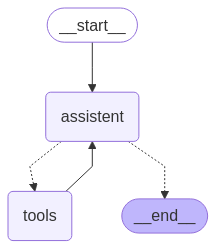

In [48]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistent",assistent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistent")
builder.add_conditional_edges("assistent",tools_condition)

builder.add_edge("tools","assistent")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [49]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [50]:
config = {"configurable": {"thread_id":"Check OceanWave files"}}

messages = [HumanMessage(content="Visualize my OceanWave3D files that I have created in the folder called Beach2. The folder is: C:/Users/Bruger/OneDrive - Danmarks Tekniske Universitet/Skrivebord/4. semester/Fagprojekt/Fagproject-AIAgent-1" \
                                "See that all fort.xxx files are relevant here." \
                                "My output path is: C:/Users/Bruger/OneDrive - Danmarks Tekniske Universitet/Skrivebord/OceanWave.gif")]

messages = react_graph.invoke({"messages":messages})

for m in messages ['messages']:
    m.pretty_print()

Attempting to visualize OceanWave3D data from: C:/Users/Bruger/OneDrive - Danmarks Tekniske Universitet/Skrivebord/4. semester/Fagprojekt/Fagproject-AIAgent-1/Beach2
Output will be saved to: C:/Users/Bruger/OneDrive - Danmarks Tekniske Universitet/Skrivebord/OceanWave.gif
Found 20 files to process.
Data appears to be on a regular grid. Using meshgrid.
Sampling files to determine Z limits...
Global Z limits set to: [-2.80, 2.75]
Creating animation (this may take a while)...
Saving animation to C:/Users/Bruger/OneDrive - Danmarks Tekniske Universitet/Skrivebord/OceanWave.gif ...
Animation saved successfully.
================================ Human Message =================================

Visualize my OceanWave3D files that I have created in the folder called Beach2. The folder is: C:/Users/Bruger/OneDrive - Danmarks Tekniske Universitet/Skrivebord/4. semester/Fagprojekt/Fagproject-AIAgent-1See that all fort.xxx files are relevant here.My output path is: C:/Users/Bruger/OneDrive - Danmar